In [1]:
import numpy as np
import pandas as pd

In [2]:
file = "/home/jarl/UniStuff/CogSci2/ccs-project/video_1/transcription/transcript_backbiter.csv"

In [31]:
OFFSET_START = 3.0 * 60.0
WINDOW_START = 7.0 * 60.0

OFFSET_END = 3.0 * 60.0
WINDOW_END = 7.0 * 60.0

## Kullback-Leibler Distance

In [32]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


def create_dist(texta, textb):
    fdist_a = FreqDist()
    fdist_b = FreqDist()

    words_a = []
    for line in texta:
        tokens = word_tokenize(line)
        words_a += [lemmatizer.lemmatize(token) for token in tokens]

    
    words_b = []
    for line in textb:
        tokens = word_tokenize(line)
        words_b += [lemmatizer.lemmatize(token) for token in tokens]
        
    for word in words_a:
        fdist_a[word.lower()] += 1
        fdist_b[word.lower()] += 0

    for word in words_b:
        fdist_b[word.lower()] += 1
        fdist_a[word.lower()] += 0

    dist_a = np.array([fdist_a.freq(word) for word in fdist_a.keys()])
    dist_b = np.array([fdist_b.freq(word) for word in fdist_b.keys()])
    
    return dist_a, dist_b

In [33]:
def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

## High frequency measure

In [34]:


def get_25(text_a, text_b):
    fdist_a = FreqDist()
    fdist_b = FreqDist()
    
    fdist_all = FreqDist()

    words_a = []
    for line in text_a:
        tokens = word_tokenize(line)
        words_a += [lemmatizer.lemmatize(token) for token in tokens]
    
    words_b = []
    for line in text_b:
        tokens = word_tokenize(line)
        words_b += [lemmatizer.lemmatize(token) for token in tokens]
    
    set_words_a = set(words_a)
    set_words_b = set(words_b)
    
    set_words_all = set_words_a.intersection(set_words_b)

    for word in words_a:
        fdist_a[word.lower()] += 1
        fdist_a

    for word in words_b:
        fdist_b[word.lower()] += 1
        fdist_all[word.lower()] += 1
        
    # get 25 most common words that are also in set_words_all
    fdist = FreqDist()
    for word in fdist_all.keys():
        if word in set_words_all:
            fdist[word] = fdist_all[word]
    
    fdist_all = fdist
    
    sum_dist = 0 
    
    for word in fdist.most_common(25):
        w_a = fdist_a[word[0]]
        w_b = fdist_b[word[0]]
        
        sum_dist += -np.abs((w_a - w_b) / word[1])
    
    
    return sum_dist


## Entrainment Beginning, End

In [35]:
import os

transcipts_head_folder = "/home/jarl/UniStuff/CogSci2/ccs-project/videos_novideos/"
transcript_files = []

for root, dirs, files in os.walk(transcipts_head_folder):
    for file in files:
        if file.endswith("backbiter.csv"):
            transcript_files.append(os.path.join(root, file))


def analysis(file):
    df = pd.read_csv(file)
    #print(file)
    #get dataframes for first and second window
    df_first_window = df.loc[df["start"] >= OFFSET_START]
    window_start = df_first_window["start"].iloc[1] + WINDOW_START
    df_first_window = df_first_window.loc[df["stop"] <= window_start]


    length = df["stop"].iloc[-1]
    df_second_window = df.loc[df["stop"] <= length - OFFSET_END]
    window_end = df_second_window["stop"].iloc[-1] - WINDOW_END
    df_second_window = df_second_window.loc[df["start"] >= window_end]
    
    sentences_pers_a_first_window = df_first_window["utterance"].iloc[::2]
    sentences_pers_b_first_window = df_first_window["utterance"].iloc[1::2]

    #TODO: Is it important to know that person a in first window is also person a in second window?
    sentences_pers_a_second_window = df_second_window["utterance"].iloc[::2]
    sentences_pers_b_second_window = df_second_window["utterance"].iloc[1::2]
    
    P_first, Q_first = create_dist(sentences_pers_a_first_window, sentences_pers_b_first_window)
    P_second, Q_second = create_dist(sentences_pers_a_second_window, sentences_pers_b_second_window)
    
    KL_first = -KL(P_first, Q_first)
    KL_second = -KL(P_second, Q_second)
    
    highfreq_first = get_25(sentences_pers_a_first_window, sentences_pers_b_first_window)
    highfreq_second = get_25(sentences_pers_a_second_window, sentences_pers_b_second_window)
    
    return KL_first, KL_second, highfreq_first, highfreq_second

data = {
    "file": [],
    "KL_first": [],
    "KL_second": [],
    "highfreq_first": [],
    "highfreq_second": []

}
for file in transcript_files:
    KL_first, KL_second, highfreq_first, highfreq_second = analysis(file)
    data["file"].append(file)
    data["KL_first"].append(KL_first)
    data["KL_second"].append(KL_second)
    data["highfreq_first"].append(highfreq_first)
    data["highfreq_second"].append(highfreq_second)
    
df = pd.DataFrame(data)
df[0:5]

,file,KL_first,KL_second,highfreq_first,highfreq_second
0,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-1.307978,-1.253998,-14.700081,-16.063714
1,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-1.822777,-1.287914,-13.987313,-13.544053
2,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-1.208200,-1.941873,-18.870868,-31.934138
3,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-1.624401,-1.560159,-13.505529,-14.341621
4,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-1.482121,-1.765777,-10.198674,-13.764987


highfreq mean diff:  -3.604243228549217
KL mean diff:  -0.05442676239865318
highfreq:  TtestResult(statistic=3.300321866994789, pvalue=0.001731536188107038, df=53)
KL:  TtestResult(statistic=1.627994792753277, pvalue=0.10945689708486502, df=53)


Text(0.5, 1.0, 'High-Frequency Words')

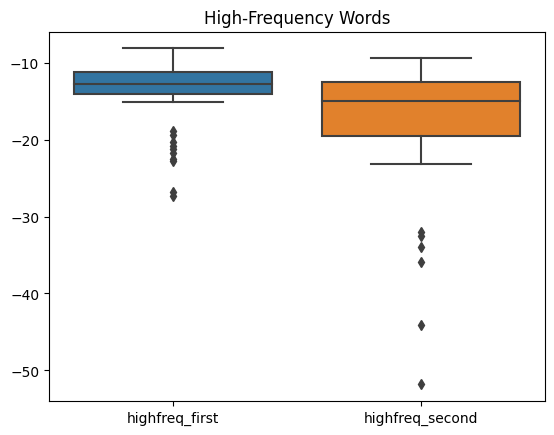

In [36]:
# mean of highfrq
#print(df["highfreq_second"].mean() - df["highfreq_first"].mean())
print("highfreq mean diff: ", df["highfreq_second"].mean() - df["highfreq_first"].mean())
print("KL mean diff: ", df["KL_second"].mean() - df["KL_first"].mean())

import scipy.stats as stats

print("highfreq: ", stats.ttest_rel(df["highfreq_first"], df["highfreq_second"]))
print("KL: ", stats.ttest_rel(df["KL_first"], df["KL_second"]))

import seaborn as sns
g = sns.boxplot(data=df[["highfreq_first", "highfreq_second"]])
g.set_title("High-Frequency Words")


Text(0.5, 1.0, 'KL Divergence')

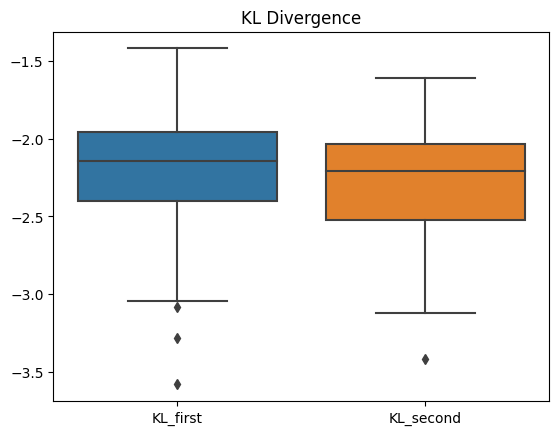

In [9]:
g = sns.boxplot(data=df[["KL_first", "KL_second"]])
g.set_title("KL Divergence")

## Entrainment global

In [21]:
import os

transcipts_head_folder = "/home/jarl/UniStuff/CogSci2/ccs-project/videos_novideos/"
transcript_files = []

for root, dirs, files in os.walk(transcipts_head_folder):
    for file in files:
        if file.endswith("backbiter.csv"):
            transcript_files.append(os.path.join(root, file))


def analysis_global(file1, all_files):
    #print(file)
    #get dataframes for first and second window
    df_file1 = pd.read_csv(file1)
    
    sentences_pers_a_file1 = df_file1["utterance"].iloc[::2]
    sentences_pers_b_file1 = df_file1["utterance"].iloc[1::2]

    KL_same = -KL(*create_dist(sentences_pers_a_file1, sentences_pers_b_file1))
    KL_a_other = []
    KL_b_other = []
    
    highfreq_same = get_25(sentences_pers_a_file1, sentences_pers_b_file1)
    highfreq_a_other = []
    highfreq_b_other = []
    
    for file in all_files:
        if file == file1:
            continue
        df_file2 = pd.read_csv(file)
        
        
        sentences_pers_a_file2 = df_file2["utterance"].iloc[::2]
        sentences_pers_b_file2 = df_file2["utterance"].iloc[1::2]
        
        KL_a_other.append(-KL(*create_dist(sentences_pers_a_file1, sentences_pers_a_file2)))
        KL_a_other.append(-KL(*create_dist(sentences_pers_a_file1, sentences_pers_b_file2)))
        
        KL_b_other.append(-KL(*create_dist(sentences_pers_b_file1, sentences_pers_a_file2)))
        KL_b_other.append(-KL(*create_dist(sentences_pers_b_file1, sentences_pers_b_file2)))
        
        highfreq_a_other.append(get_25(sentences_pers_a_file1, sentences_pers_a_file2))
        highfreq_a_other.append(get_25(sentences_pers_a_file1, sentences_pers_b_file2))
        
        highfreq_b_other.append(get_25(sentences_pers_b_file1, sentences_pers_a_file2))
        highfreq_b_other.append(get_25(sentences_pers_b_file1, sentences_pers_b_file2))
        
        
    KL_a_other = np.mean(KL_a_other)
    KL_b_other = np.mean(KL_b_other)
    
    highfreq_a_other = np.mean(highfreq_a_other)
    highfreq_b_other = np.mean(highfreq_b_other)
    
    return KL_same, KL_a_other, KL_b_other, highfreq_same, highfreq_a_other, highfreq_b_other

data = {
    "file": [],
    "KL_same": [],
    "KL_a_other": [],
    "KL_b_other": [],
    "highfreq_same": [],
    "highfreq_a_other": [],
    "highfreq_b_other": [],
}

for file in transcript_files:
    
    file2 = np.random.choice(transcript_files)
    while file2 == file:
        file2 = np.random.choice(transcript_files)
    
    KL_same, KL_a_other, KL_b_other, highfreq_same, highfreq_a_other, highfreq_b_other = analysis_global(file, transcript_files)
    data["file"].append(file)
    data["KL_same"].append(KL_same)
    data["KL_a_other"].append(KL_a_other)
    data["KL_b_other"].append(KL_b_other)
    data["highfreq_same"].append(highfreq_same)
    data["highfreq_a_other"].append(highfreq_a_other)
    data["highfreq_b_other"].append(highfreq_b_other)
    
df_global = pd.DataFrame(data)
df_global[0:5]

,file,KL_same,KL_a_other,KL_b_other,highfreq_same,highfreq_a_other,highfreq_b_other
0,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-0.690813,-0.763534,-0.849554,-16.051854,-12.185541,-12.199230
1,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-0.739410,-0.868946,-0.852409,-14.231530,-20.381670,-10.559546
2,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-0.742346,-0.887917,-0.867698,-12.612151,-12.855390,-13.271850
3,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-0.889517,-0.854890,-0.908179,-17.062743,-9.989062,-11.909928
4,/home/jarl/UniStuff/CogSci2/ccs-project/videos...,-0.560848,-0.831252,-0.775808,-7.853821,-25.593816,-20.047415


In [40]:
# mean of highfrq
print("highfreq_a mean ", df_global["highfreq_same"].mean() - df_global["highfreq_a_other"].mean())
print("highfreq_b mean:", df_global["highfreq_same"].mean() - df_global["highfreq_b_other"].mean())

print("Kl_a mean:", df_global["KL_same"].mean() - df_global["KL_a_other"].mean())
print("KL_b mean:", df_global["KL_same"].mean() - df_global["KL_b_other"].mean())

import scipy.stats as stats

print("highfreq_a: ", stats.ttest_rel(df_global["highfreq_same"], df_global["highfreq_a_other"]))
print("highfreq_b: ", stats.ttest_rel(df_global["highfreq_same"], df_global["highfreq_b_other"]))

print("KL_a: ", stats.ttest_rel(df_global["KL_same"], df_global["KL_a_other"]))
print("KL_b: ", stats.ttest_rel(df_global["KL_same"], df_global["KL_b_other"]))

highfreq_a mean  1.3495674062796912
highfreq_b mean: 0.6493277162643292
Kl_a mean: 0.16473106992289344
KL_b mean: 0.17873255117982367
highfreq_a:  TtestResult(statistic=2.0082295469126823, pvalue=0.04972708097251039, df=53)
highfreq_b:  TtestResult(statistic=0.8609109782441221, pvalue=0.3931651546798649, df=53)
KL_a:  TtestResult(statistic=14.83481289547895, pvalue=1.6394836755369746e-20, df=53)
KL_b:  TtestResult(statistic=11.351285554358757, pvalue=8.321028963418479e-16, df=53)


In [12]:
#Although conversation not very restricted in terms of topics, hence it may not be surprising that it is different